# Monopoly board simulator

My girlfriend asked me to play Monopoly with her and I declined becuase I feel that the game 1) sets people against eachother, and 2) it has a definite "best strategy" for how to win. This last part makes game borring for me. All you have to do is set probability on your side then sit back and wait.

I wasn't content to just google the answer, so instead I set out to determine the probability of landing on each ownable property, thus giving a first order solution at a Monopoly best strategy.

### 1- Make a dice roller

In [1]:
from numpy.random import default_rng
rng = default_rng()

In [2]:
samples = rng.integers(low = 1, high = 6, size = 10, endpoint=True)
print(samples)

[1 3 2 1 2 2 4 6 4 2]


In [3]:
# let's plot dice rolls as historgram

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
histo, edges = np.histogram(samples, bins=np.arange(1,8))

In [6]:
print(histo)

[2 4 1 2 0 1]


In [7]:
print(edges)

[1 2 3 4 5 6 7]


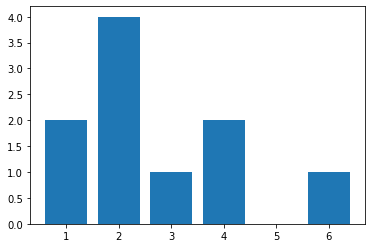

In [8]:
plt.bar(edges[:6], histo)
plt.show()

In [9]:
# Lets roll a few thousand more times

In [10]:
samples_large = rng.integers(low = 1, high = 6, size = 100000, endpoint=True)

In [11]:
histo, edges = np.histogram(samples_large, bins=np.arange(1,8))

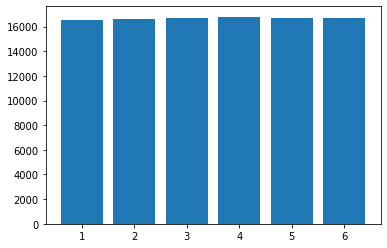

In [12]:
plt.bar(edges[:6], histo)
plt.show()

We get a mostly uniform distribution by rolling one dice many many times

We could be more rigorous here and see what the deviation is. But for now, let's continue

Monopoly doesn't just have one dice, but two. Let's roll both of them at the same time

In [13]:
# measuring values of two indpendent dice rolls added together
# here we expect some non-uniform probability centered around 7
samples_a = rng.integers(low = 1, high = 6, size = 100000, endpoint=True)
samples_b = rng.integers(low = 1, high = 6, size = 100000, endpoint=True)
samples_sum = samples_a+samples_b

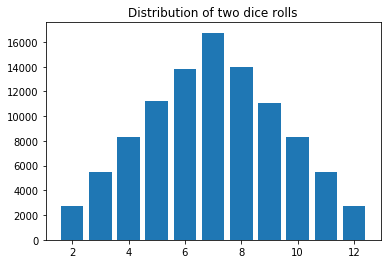

In [14]:
histo, edges = np.histogram(samples_sum, bins=np.arange(2,14))
plt.bar(edges[:11], histo)
plt.title("Distribution of two dice rolls" )
plt.show()

## 2- Walk around a game board

In [15]:
# now let's have our two dice move our piece around the Monopoly board
# each monopoly board has 40 spaces. we will have "Go" be at 0, and "Boardwalk" be at 39

In [16]:
# the space you land on is your current throw, plus all previous throws
# start at 0
space = 0
position_history = [0]
for i in np.arange(len(samples_sum)):
    position_history.append(space + samples_sum[i])
    space += samples_sum[i]
    
print(space)

699695


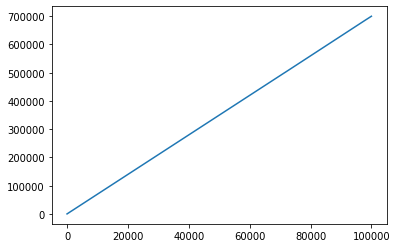

In [17]:
plt.plot(np.arange(len(position_history)), position_history)
plt.show()

In [18]:
# the board is cyclic, so reset every 40 spaces
board_position = np.asarray(position_history)%40

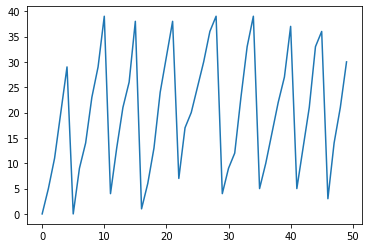

In [19]:
plt.plot(np.arange(len(board_position[:50])), board_position[:50])
plt.show()

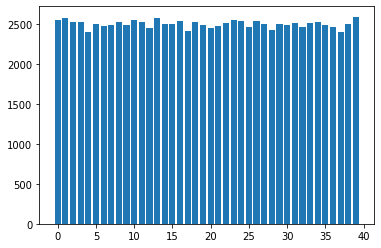

In [20]:
# let's check distribution over all spaces 
histo, edges = np.histogram(board_position, bins=np.arange(41))
plt.bar(edges[:40], histo)
plt.show()

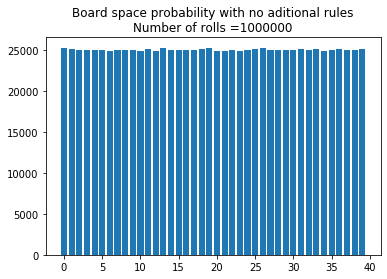

In [21]:
# this looks mostly uniform.
# let's run a couple thousand more times just to make sure
n_rolls = 1000000
samples_a = rng.integers(low = 1, high = 6, size = n_rolls, endpoint=True)
samples_b = rng.integers(low = 1, high = 6, size = n_rolls, endpoint=True)
samples_sum = samples_a+samples_b

space = 0
position_history = [0]
for i in np.arange(len(samples_sum)):
    position_history.append(space + samples_sum[i])
    space += samples_sum[i]
    
board_position = np.asarray(position_history)%40

histo, edges = np.histogram(board_position, bins=np.arange(41))
plt.bar(edges[:40], histo)
plt.title("Board space probability with no aditional rules\nNumber of rolls ="+str(n_rolls) )
plt.show()

This looks good. With no additional rules, rolling two dice at once over and over again we expect that we will have equal likelyhood of ending up on any given position

## 3- Adding game board rules

Landing on certain spaces causes you to 'jump' to other spaces.

At this point we need to get a little more sophistocated about our board walking logic

In [22]:
# a turn consists of 
# 1) rolling dice
# 2) moving to a space
# 3) check if there are special rules about that space
# 4) special rules cause you to jump to a new space

### Jail

In [23]:
# for now let's just add jail
def check_special_rules(space):
    if space == 30:
        return 10
    return space % 40

In [24]:
# while we're at it let's make a helper for dice rolls too
def roll_dice(nrolls = 10000):
    samples_a = rng.integers(low = 1, high = 6, size = nrolls, endpoint=True)
    samples_b = rng.integers(low = 1, high = 6, size = nrolls, endpoint=True)
    samples_sum = samples_a+samples_b
    return samples_sum

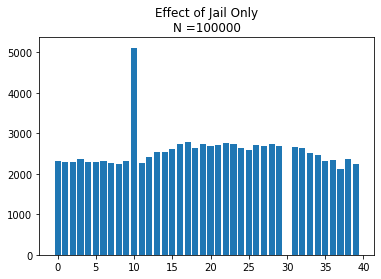

In [25]:
n_rolls = 100000
dice_rolls = roll_dice(n_rolls)

space = 0
board_positions = [0]
for i in np.arange(len(dice_rolls)):
    space = check_special_rules(space + dice_rolls[i])
    board_positions.append(space)

histo, edges = np.histogram(board_positions, bins=np.arange(41))
plt.bar(edges[:40], histo)
plt.title("Effect of Jail Only\nN ="+str(n_rolls) )
plt.show()

Alright, interesting things are starting to happen. You can land on jail while "just visiting", and also immediatly after you land on jail space, so the probability is rightly doubled. Additinoally, the spaces immediatly after jail gain some additional probability, while those immediatly after jail lose some probability

Let's add some more rules

### Chance

In [26]:
class Chance:
    def no_move(self, arg):
        return arg
    
    # ride reading railroad
    def rrr_move(self, arg):
        return 4
    
    def go_jail_move(self, arg):
        return 10
    
    # nearest utility
    def n_u_move(self, space):
        if space < 12:
            return 12
        elif space < 28:
            return 28
        else:
            return 12
    
    # nearest railroad
    def n_r_move(self, space):
        if space < 5:
            return 5
        elif space < 15:
            return 15
        elif space < 25:
            return 25
        elif space < 35:
            return 35
        else:
            return 5
        
    def gb3_move(self, space):
        return space - 3
    
    def g2g_move(self, arg):
        return 0
    
    # Illinois Ave.
    def ia_move(self, arg):
        return 24
    
    # St. Charles Place
    def scp_move(self, arg):
        return 11
    
    # Boardwalk
    def b_move(self, arg):
        return 39
    
    deck = {
        0: {
            "name": "Reading Railroad",
            "move": rrr_move
        },
        1: {
            "name": "Property Repairs",
            "move": no_move
        },
        2: {
            "name": "Go To Jail",
            "move": go_jail_move
        },
        3: {
            "name": "Poor Tax",
            "move": no_move
        },
        4: {
            "name": "Nearest Utility",
            "move": n_u_move
        },
        5: {
            "name": "Nearest Railroad",
            "move": n_r_move
        },
        6: {
            # yes there are two of these cards
            "name": "Nearest Railroad 2",
            "move": n_r_move
        },
        7: {
            "name": "Go Back 3",
            "move": gb3_move
        },
        8: {
            "name": "Go to Go",
            "move": g2g_move
        },
        9: {
            "name": "Illinois Ave.",
            "move": ia_move
        },
        10: {
            "name": "St. Charles Place",
            "move": scp_move
        },
        11: {
            "name": "Receive Dividend",
            "move": no_move
        },
        12: {
            "name": "Building and Loan",
            "move": no_move
        },
        13: {
            "name": "Get Out of Jail Free",
            "move": no_move
        },
        14: {
            "name": "Go to Boardwalk",
            "move": b_move
        },
        15: {
            "name": "Elected Chairman",
            "move": no_move
        }
    }
    
    deck_order = np.arange(len(deck))
    position_in_deck = 0
    
    def shuffle_deck(self):
        np.random.shuffle(self.deck_order)
    
    def pick_card(self, space):
        if self.position_in_deck > len(self.deck_order)-1:
            self.shuffle_deck()
            self.position_in_deck = 0
        
        # handle card picking and iterating tasks
        card = self.deck_order[self.position_in_deck]
        self.position_in_deck +=1
        
        # handle card resolution tasks
        new_space = self.deck[card]["move"](self, space)
        
        return new_space

    
## Initialize Chance deck
c_deck = Chance()

In [27]:
# Let's try picking 10 cards at random
# We say for now that we are on space 0, or 'Go' just to have a place to be
# If the card has instructions for us to jump to a new space it will tell us what space we should go to from here, 
# otherwise our current space is returned

for i in range(10):
    print(c_deck.pick_card(space = 0))

4
0
10
0
12
5
5
-3
0
24


In [28]:
# For now lets check what chance does without including default jail rules 
def check_special_rules(space):
    # Jail
    # if space == 30:
    #     return 10
    
    # Chance
    if space in [7, 22, 36]:
        new_space = c_deck.pick_card(space)
        if new_space != space:
            return check_special_rules(new_space) % 40
        else:
            return new_space % 40
    
    return space % 40

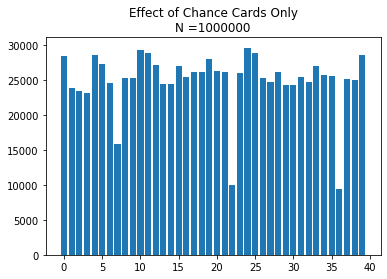

In [29]:
n_rolls = 1000000
dice_rolls = roll_dice(n_rolls)

space = 0
board_positions = [0]
for i in np.arange(len(dice_rolls)):
    space = check_special_rules(space + dice_rolls[i])
    board_positions.append(space)

histo, edges = np.histogram(board_positions, bins=np.arange(41))
plt.bar(edges[:40], histo)
plt.title("Effect of Chance Cards Only\nN ="+str(n_rolls) )
plt.show()

In [30]:
# And now including chance and jail 
def check_special_rules(space):
    # Jail
    if space == 30:
        return 10
    
    # Chance
    if space in [7, 22, 36]:
        new_space = c_deck.pick_card(space)
        if new_space != space:
            return check_special_rules(new_space) % 40
        else:
            return new_space % 40
    
    return space % 40

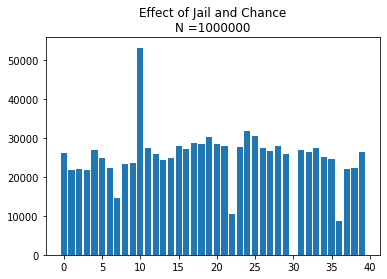

In [31]:
n_rolls = 1000000
dice_rolls = roll_dice(n_rolls)

space = 0
board_positions = [0]
for i in np.arange(len(dice_rolls)):
    space = check_special_rules(space + dice_rolls[i])
    board_positions.append(space)

histo, edges = np.histogram(board_positions, bins=np.arange(41))
plt.bar(edges[:40], histo)
plt.title("Effect of Jail and Chance\nN ="+str(n_rolls) )
plt.show()

### Community Chest

In [32]:
class CommunityChest:
    def no_move(self, arg):
        return arg
    
    def go_jail_move(self, arg):
        return 10
    
    def g2g_move(self, arg):
        return 0
    
    deck = {
        0: {
            "name": "Life Insurance",
            "move": no_move
        },
        1: {
            "name": "Bank Error",
            "move": no_move
        },
        2: {
            "name": "Go To Jail",
            "move": go_jail_move
        },
        3: {
            "name": "Collect $50 From Every Player",
            "move": no_move
        },
        4: {
            "name": "Pay Hospital",
            "move": no_move
        },
        5: {
            "name": "XMAS Fund Matures",
            "move": no_move
        },
        6: {
            "name": "Get Out of Jail Free",
            "move": no_move
        },
        7: {
            "name": "Pay School Tax",
            "move": no_move
        },
        8: {
            "name": "Inherit $100",
            "move": no_move
        },
        9: {
            "name": "Go to Go",
            "move": g2g_move
        },
        10: {
            "name": "Doctor's Fee",
            "move": no_move
        },
        11: {
            "name": "Receive For Services",
            "move": no_move
        },
        12: {
            "name": "Assessed Street Repairs",
            "move": no_move
        },
        13: {
            "name": "Beauty Contest",
            "move": no_move
        },
        14: {
            "name": "Sale of Stock",
            "move": no_move
        },
        15: {
            "name": "Income Tax Refund",
            "move": no_move
        }
    }
    
    deck_order = np.arange(len(deck))
    position_in_deck = 0
    
    def shuffle_deck(self):
        np.random.shuffle(self.deck_order)
    
    def pick_card(self, space):
        if self.position_in_deck > len(self.deck_order)-1:
            self.shuffle_deck()
            self.position_in_deck = 0
        
        # handle card picking and iterating tasks
        card = self.deck_order[self.position_in_deck]
        self.position_in_deck +=1
        
        # handle card resolution tasks
        new_space = self.deck[card]["move"](self, space)
        
        return new_space

In [33]:
cc_deck = CommunityChest()

In [34]:
# Let's look at just Community Chest
def check_special_rules(space):
    # Jail
    #if space == 30:
    #    return 10
    
    # Chance
    #if space in [7, 22, 36]:
    #    new_space = c_deck.pick_card(space)
    #    if new_space != space:
    #        return check_special_rules(new_space) % 40
    #    else:
    #        return new_space % 40
        
    # Community Chest
    if space in [2, 17, 33]:
        new_space = cc_deck.pick_card(space)
        if new_space != space:
            return check_special_rules(new_space) % 40
        else:
            return new_space % 40
    
    return space % 40

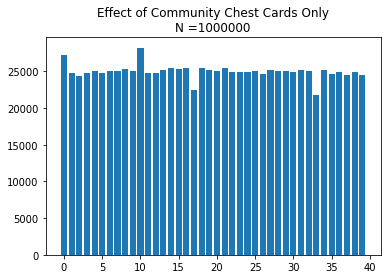

In [35]:
n_rolls = 1000000
dice_rolls = roll_dice(n_rolls)

space = 0
board_positions = [0]
for i in np.arange(len(dice_rolls)):
    space = check_special_rules(space + dice_rolls[i])
    board_positions.append(space)

histo, edges = np.histogram(board_positions, bins=np.arange(41))
plt.bar(edges[:40], histo)
plt.title("Effect of Community Chest Cards Only\nN ="+str(n_rolls) )
plt.show()

In [36]:
# Let's look at Community Chest, with Chance and Jail
def check_special_rules(space):
    # Jail
    if space == 30:
        return 10
    
    # Chance
    if space in [7, 22, 36]:
        new_space = c_deck.pick_card(space)
        if new_space != space:
            return check_special_rules(new_space) % 40
        else:
            return new_space % 40
        
    # Community Chest
    if space in [2, 17, 33]:
        new_space = cc_deck.pick_card(space)
        if new_space != space:
            return check_special_rules(new_space) % 40
        else:
            return new_space % 40
    
    return space % 40

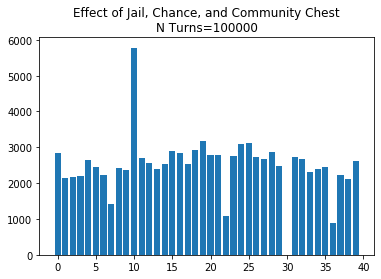

In [37]:
n_rolls = 100000
dice_rolls = roll_dice(n_rolls)

space = 0
board_positions = [0]
for i in np.arange(len(dice_rolls)):
    space = check_special_rules(space + dice_rolls[i])
    board_positions.append(space)

histo, edges = np.histogram(board_positions, bins=np.arange(41))
plt.bar(edges[:40], histo)
plt.title("Effect of Jail, Chance, and Community Chest\nN Turns="+str(n_rolls) )
plt.show()

## 4- Presentation

In [38]:
# Let's start putting space names in
game_board = {
    0: {
        "name": "Go",
        "color": "Black"
    },
    1: {
        "name": "Mediteranean Ave",
        "color": "Purple"
    },
    2: {
        "name": "Community Chest",
        "color": "Black"
    },
    3: {
        "name": "Baltic Ave",
        "color": "Purple"
    },
    4: {
        "name": "Income Tax",
        "color": "Black"
    },
    5: {
        "name": "Reading Railroad",
        "color": "gray"
    },
    6: {
        "name": "Oriental Ave", 
        "color": "cyan"
    },
    7: {
        "name": "Chance",
        "color": "pink"
    },
    8: {
        "name": "Vermont Ave",
        "color": "cyan"
    },
    9: {
        "name": "Connecticut Ave",
        "color": "cyan"
    },
    10: {
        "name": "Jail",
        "color": "black"
    },
    11: {
        "name": "St. Charles Place",
        "color": "magenta"
    },
    12: {
        "name": "Electric Company",
        "color": "brown"
    },
    13: {
        "name": "States Ave",
        "color": "magenta"
    },
    14: {
        "name": "Virginia Ave",
        "color": "magenta"
    },
    15: {
        "name": "Pensylvania Railroad",
        "color": "gray"
    },
    16: {
        "name": "St. James Place",
        "color": "orange"
    },
    17: {
        "name": "Community Chest",
        "color": "black"
    },
    18: {
        "name": "Tennessee Ave",
        "color": "orange"
    },
    19: {
        "name": "New York Ave",
        "color": "orange"
    },
    20: {
        "name": "Free Parking",
        "color": "black"
    },
    21: {
        "name": "Kentucky Ave",
        "color": "red"
    },
    22: {
        "name": "Chance",
        "color": "pink"
    },
    23: {
        "name": "Indiana Ave",
        "color": "red"
    },
    24: {
        "name": "Illinois Ave",
        "color": "red"
    },
    25: {
        "name": "B&O Railroad",
        "color": "gray"
    },
    26: {
        "name": "Atlantic Ave",
        "color": "yellow"
    },
    27: {
        "name": "Ventnor Ave",
        "color": "yellow"
    },
    28: {
        "name": "Water Works",
        "color": "brown"
    },
    29: {
        "name": "Marvin Gardens",
        "color": "yellow"
    },
    30: {
        "name": "Go To Jail",
        "color": "black"
    },
    31: {
        "name": "Pacific Ave",
        "color": "green"
    },
    32: {
        "name": "North Carolina Ave",
        "color": "green"
    },
    33: {
        "name": "Community Chest",
        "color": "black"
    },
    34: {
        "name": "Pennsylvania Ave",
        "color": "green"
    },
    35: {
        "name": "Short Line Railroad",
        "color": "gray"
    },
    36: {
        "name": "Chance",
        "color": "pink"
    },
    37: {
        "name": "Park Place",
        "color": "blue"
    },
    38: {
        "name": "Luxury Tax",
        "color": "black"
    },
    39: {
        "name": "Boardwalk",
        "color": "blue"
    }
}

In [39]:
x_labels = []
x_label_colors = []
for i in range(40):
    x_labels.append(game_board[i]["name"])
    x_label_colors.append(game_board[i]["color"])

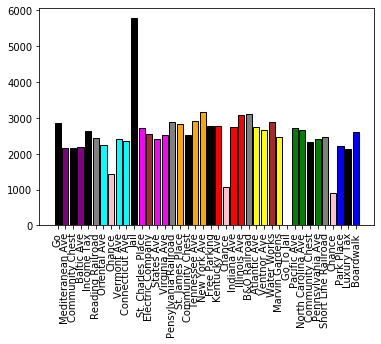

In [40]:
plt.bar(edges[:40], histo, color = x_label_colors, edgecolor='black')
plt.xticks(np.arange(40), x_labels, rotation=90)
plt.show()

In [41]:
# next let's find average of all ownable properties
total = 0
possible_properties = [1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 35, 37, 39]
for i in possible_properties:
    total += histo[i]

average = total / len(possible_properties)
print(average)

2622.0


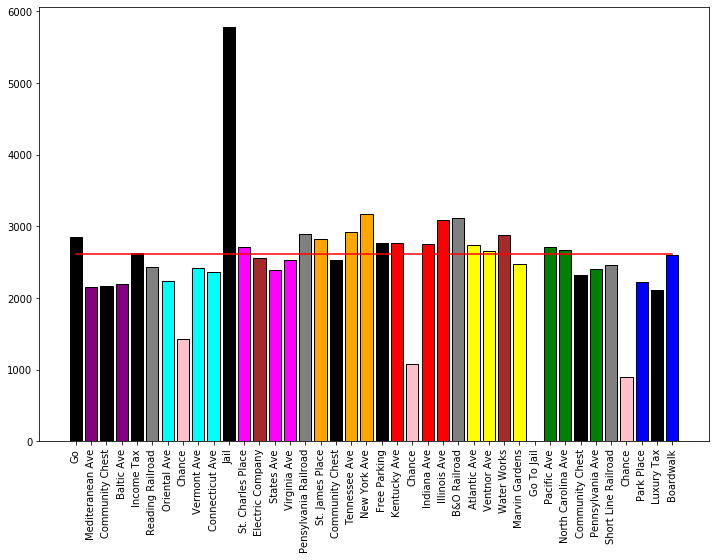

In [42]:
plt.figure(figsize=(12,8))
plt.bar(edges[:40], histo, color = x_label_colors, edgecolor='black')
plt.plot([0, 39],[average, average], color='red')
plt.xticks(np.arange(40), x_labels, rotation=90)

plt.show()